In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as f
from pyspark.ml.feature import VectorAssembler
import pyspark.sql.types as typ
import pandas as pd
import  pyspark.ml.feature as ft
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.classification import RandomForestClassifier
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator 
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
from pyspark.ml.feature import QuantileDiscretizer
import pyspark.ml.classification as cl

# 读取数据

In [2]:
session = SparkSession.builder.master("local[*]").appName("test").getOrCreate()

In [3]:
labels = [('loan_id', typ.IntegerType()),
          ('user_id', typ.IntegerType()),
          ('total_loan', typ.DoubleType()),
          ('year_of_loan', typ.IntegerType()),
          ('interest', typ.DoubleType()),
          ('monthly_payment', typ.DoubleType()),
          ('class', typ.StringType()),
          ('sub_class', typ.StringType()),
          ('work_type', typ.StringType()),
          ('employment_type', typ.StringType()),
          ('industry', typ.StringType()),
          ('work_year', typ.StringType()),
          ('house_exist', typ.IntegerType()),
          ('house_loan_status', typ.IntegerType()),
          ('censor_status', typ.IntegerType()),
          ('marriage', typ.IntegerType()),
          ('offsprings', typ.IntegerType()),
          ('issue_date', typ.StringType()),
          ('use', typ.IntegerType()),
          ('post_code', typ.DoubleType()),
          ('region', typ.IntegerType()),
          ('debt_loan_ratio', typ.DoubleType()),
          ('del_in_18month', typ.DoubleType()),
          ('scoring_low', typ.DoubleType()),
          ('scoring_high', typ.DoubleType()),
          ('pub_dero_bankrup', typ.DoubleType()),
          ('early_return', typ.IntegerType()),
          ('early_return_amount', typ.IntegerType()),
          ('early_return_amount_3mon', typ.DoubleType()),
          ('recircle_b', typ.DoubleType()),
          ('recircle_u', typ.DoubleType()),
          ('initial_list_status', typ.IntegerType()),
          ('earlies_credit_mon', typ.StringType()),
          ('title', typ.DoubleType()),
          ('policy_code', typ.DoubleType()),
          ('f0', typ.DoubleType()),
          ('f1', typ.DoubleType()),
          ('f2', typ.DoubleType()),
          ('f3', typ.DoubleType()),
          ('f4', typ.DoubleType()),
          ('f5', typ.DoubleType()),
          ('is_default', typ.IntegerType()),
          ]

In [4]:
schema = typ.StructType([
    typ.StructField(e[0], e[1], True) for e in labels
])

In [5]:
df = session.read.csv("train_data.csv", encoding="utf-8", header=True, schema=schema)

# 填充缺失值

In [6]:
df = df.na.fill(-1)
df = df.na.fill('-1')

# 类别特征编码

In [7]:
strings = ['class', 'sub_class', 'work_type', 'employment_type', 'industry', 'work_year', 'issue_date', 'earlies_credit_mon']

In [8]:
indexes = [StringIndexer(inputCol =s, outputCol=s+"_ind") for s in strings]
pipeline = Pipeline(stages=indexes)

In [9]:
tmodel = pipeline.fit(df)
dfres = tmodel.transform(df)

In [10]:
dfres = dfres.drop(*strings)

In [11]:
dfres.select("issue_date_ind", "earlies_credit_mon_ind").show(10)

+--------------+----------------------+
|issue_date_ind|earlies_credit_mon_ind|
+--------------+----------------------+
|          13.0|                 335.0|
|          98.0|                 248.0|
|          18.0|                  90.0|
|          52.0|                  38.0|
|          45.0|                  36.0|
|          18.0|                  44.0|
|           2.0|                   5.0|
|          19.0|                  59.0|
|          69.0|                  45.0|
|          44.0|                 189.0|
+--------------+----------------------+
only showing top 10 rows



# 时间特征分桶

In [12]:
discretizers = [QuantileDiscretizer(numBuckets=20, inputCol=s, outputCol=s+"b") for s in ["issue_date_ind", "earlies_credit_mon_ind"]]
pipeline = Pipeline(stages=discretizers)
bmodel = pipeline.fit(dfres)
dfres = bmodel.transform(dfres)

In [13]:
dfres.select("issue_date_ind", "earlies_credit_mon_ind", "issue_date_indb", "earlies_credit_mon_indb").show(10)

+--------------+----------------------+---------------+-----------------------+
|issue_date_ind|earlies_credit_mon_ind|issue_date_indb|earlies_credit_mon_indb|
+--------------+----------------------+---------------+-----------------------+
|          13.0|                 335.0|            7.0|                   18.0|
|          98.0|                 248.0|           19.0|                   17.0|
|          18.0|                  90.0|            8.0|                    9.0|
|          52.0|                  38.0|           16.0|                    4.0|
|          45.0|                  36.0|           15.0|                    4.0|
|          18.0|                  44.0|            8.0|                    5.0|
|           2.0|                   5.0|            1.0|                    0.0|
|          19.0|                  59.0|            9.0|                    6.0|
|          69.0|                  45.0|           18.0|                    5.0|
|          44.0|                 189.0| 

In [14]:
dfres = dfres.drop("issue_date_ind", "earlies_credit_mon_ind")

# 准备训练集和测试集

In [15]:
data = dfres.drop('is_default')
feas = data.columns

In [16]:
df_assembler = VectorAssembler(inputCols=data.columns, outputCol="features")
data = df_assembler.transform(dfres)

In [17]:
data.select(['features','is_default']).show(3)

+--------------------+----------+
|            features|is_default|
+--------------------+----------+
|[119262.0,0.0,120...|         1|
|[369815.0,1.0,800...|         0|
|[787833.0,2.0,200...|         0|
+--------------------+----------+
only showing top 3 rows



In [18]:
train_data, test_data = data.randomSplit([0.8,0.2]) 

In [28]:
rawpre.select("is_default").groupBy("is_default").count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         1|12004|
|         0|48185|
+----------+-----+



In [29]:
(48185 - 12004) / (48185 + 12004)

0.6011231288109123

# Logistic回归

In [19]:
logistic = cl.LogisticRegression(maxIter=10, regParam=0.01, labelCol='is_default').fit(train_data)

In [20]:
predictions = logistic.transform(test_data)

In [21]:
predictions.select(['probability','is_default','prediction']).show(10,False)

+-----------------------------------------+----------+----------+
|probability                              |is_default|prediction|
+-----------------------------------------+----------+----------+
|[0.8267113848536604,0.1732886151463396]  |0         |0.0       |
|[0.881833793550171,0.11816620644982896]  |0         |0.0       |
|[0.9819360099342933,0.01806399006570665] |0         |0.0       |
|[0.9917242440724328,0.008275755927567135]|0         |0.0       |
|[0.7093473737950583,0.29065262620494176] |0         |0.0       |
|[0.6064231854407662,0.39357681455923377] |1         |0.0       |
|[0.9846772832681061,0.015322716731893815]|0         |0.0       |
|[0.7298858688691958,0.2701141311308041]  |0         |0.0       |
|[0.9352978333397659,0.06470216666023396] |0         |0.0       |
|[0.6599062502489018,0.34009374975109813] |0         |0.0       |
+-----------------------------------------+----------+----------+
only showing top 10 rows



In [25]:
predictions.select('prediction').groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|55687|
|       1.0| 4502|
+----------+-----+



In [22]:
auc = BinaryClassificationEvaluator(labelCol='is_default').evaluate(predictions)
print('BinaryClassificationEvaluator 准确性： {0:.0%}'.format(auc))

BinaryClassificationEvaluator 准确性： 80%


# SVM

In [ ]:
svm = cl.LinearSVC(maxIter=100, labelCol='is_default').fit(train_data)

In [ ]:
predictions = logistic.transform(test_data)

In [ ]:
auc = BinaryClassificationEvaluator(labelCol='is_default').evaluate(predictions)
print('BinaryClassificationEvaluator 准确性： {0:.0%}'.format(auc))

# 神经网络

In [29]:
layers = [42, 64, 32, 1]
trainer = cl.MultilayerPerceptronClassifier(maxIter=10000, layers=layers, blockSize=128, labelCol='is_default').fit(train_data)

Py4JJavaError: An error occurred while calling o952.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 7 in stage 100.0 failed 1 times, most recent failure: Lost task 7.0 in stage 100.0 (TID 569, localhost, executor driver): org.apache.spark.SparkException: Failed to execute user defined function($anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1: (double, int) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1073)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1089)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Unseen value: 1.0. To handle unseen values, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:257)
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:243)
	... 29 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD.count(RDD.scala:1213)
	at org.apache.spark.mllib.optimization.LBFGS$.runLBFGS(LBFGS.scala:195)
	at org.apache.spark.mllib.optimization.LBFGS.optimize(LBFGS.scala:142)
	at org.apache.spark.ml.ann.FeedForwardTrainer.train(Layer.scala:854)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$train$1.apply(MultilayerPerceptronClassifier.scala:249)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier$$anonfun$train$1.apply(MultilayerPerceptronClassifier.scala:205)
	at org.apache.spark.ml.util.Instrumentation$$anonfun$11.apply(Instrumentation.scala:185)
	at scala.util.Try$.apply(Try.scala:192)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:185)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:205)
	at org.apache.spark.ml.classification.MultilayerPerceptronClassifier.train(MultilayerPerceptronClassifier.scala:114)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Failed to execute user defined function($anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1: (double, int) => struct<type:tinyint,size:int,indices:array<int>,values:array<double>>)
	at org.apache.spark.sql.catalyst.expressions.GeneratedClass$GeneratedIteratorForCodegenStage1.processNext(Unknown Source)
	at org.apache.spark.sql.execution.BufferedRowIterator.hasNext(BufferedRowIterator.java:43)
	at org.apache.spark.sql.execution.WholeStageCodegenExec$$anonfun$13$$anon$1.hasNext(WholeStageCodegenExec.scala:636)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$GroupedIterator.takeDestructively(Iterator.scala:1073)
	at scala.collection.Iterator$GroupedIterator.go(Iterator.scala:1089)
	at scala.collection.Iterator$GroupedIterator.fill(Iterator.scala:1126)
	at scala.collection.Iterator$GroupedIterator.hasNext(Iterator.scala:1130)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at scala.collection.Iterator$$anon$11.hasNext(Iterator.scala:409)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsValues(MemoryStore.scala:299)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1165)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: org.apache.spark.SparkException: Unseen value: 1.0. To handle unseen values, set Param handleInvalid to keep.
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:257)
	at org.apache.spark.ml.feature.OneHotEncoderModel$$anonfun$org$apache$spark$ml$feature$OneHotEncoderModel$$encoder$1.apply(OneHotEncoderEstimator.scala:243)
	... 29 more


In [41]:
predictions = trainer.transform(test_data)

In [ ]:
auc = BinaryClassificationEvaluator(labelCol='is_default').evaluate(predictions)
print('BinaryClassificationEvaluator 准确性： {0:.0%}'.format(auc))

# 随机森林

In [23]:
cla = RandomForestClassifier(labelCol='is_default', maxDepth=7, maxBins=700, numTrees=30).fit(train_data)

In [24]:
predictions = cla.transform(test_data)

<BarContainer object of 41 artists>

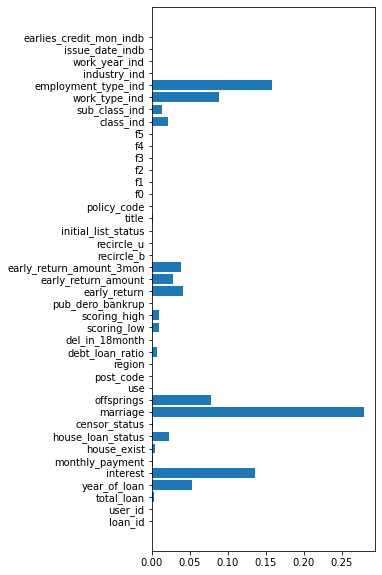

In [25]:
fig = plt.figure(figsize=(4,10))
plt.barh(feas, cla.featureImportances)

In [26]:
predictions.select(['probability','is_default','prediction']).show(10,False)

+----------------------------------------+----------+----------+
|probability                             |is_default|prediction|
+----------------------------------------+----------+----------+
|[0.9125898214980858,0.08741017850191424]|0         |0.0       |
|[0.8946871990948699,0.10531280090512997]|0         |0.0       |
|[0.8052454309770795,0.19475456902292054]|0         |0.0       |
|[0.5731165324604696,0.42688346753953044]|1         |0.0       |
|[0.9085597813031216,0.09144021869687834]|0         |0.0       |
|[0.5742823194904226,0.42571768050957737]|1         |0.0       |
|[0.8033489972013799,0.19665100279862013]|0         |0.0       |
|[0.8314498017743488,0.16855019822565118]|1         |0.0       |
|[0.9217191528985594,0.07828084710144048]|0         |0.0       |
|[0.9501597808908339,0.04984021910916619]|0         |0.0       |
+----------------------------------------+----------+----------+
only showing top 10 rows



In [27]:
auc = BinaryClassificationEvaluator(labelCol='is_default').evaluate(predictions)
print('BinaryClassificationEvaluator 准确性： {0:.0%}'.format(auc))

BinaryClassificationEvaluator 准确性： 85%


In [28]:
cla.save("CP_model2")

Py4JJavaError: An error occurred while calling o936.save.
: java.io.IOException: Path CP_model2 already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:702)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:179)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
